# Обучение (Fitting)

Задача алгоритма во время обучения -- минимизировать cost-функцию (= функцию потерь), то есть подобрать наилучшее подпространство, куда *наиболее оптимальным образом* проецируются датапоинты

<img alt="" class="ur vg fi fu fr kw v c" width="405" height="417" role="presentation" src="https://miro.medium.com/max/810/1*UUHvSixG7rX2EfNFTtqBDA.gif" srcset="https://miro.medium.com/max/552/1*UUHvSixG7rX2EfNFTtqBDA.gif 276w, https://miro.medium.com/max/810/1*UUHvSixG7rX2EfNFTtqBDA.gif 405w" sizes="405px">


([подробнее про cost function](https://towardsdatascience.com/machine-learning-fundamentals-via-linear-regression-41a5d11f5220))

## пример-напоминание

Предположим, мы хотим определить цену машины по таким параметрам:

- пробег
- мощность в лошадиных силах,
- тип топлива,
- потребление топлива (литров за 1 км) 
- количество дверей,
 
Кажется, цена может быть линейно связана с каким-то показателем (например, с потреблением топлива)
price = a + b * l/km

Как найти a и b?  Это - параметры прямой (от них будет зависеть ее наклон и положение в пространстве)

Какая линия -- лучшая? Лучшая линия -- та, которая отражает положение данных. С одним параметром это не сложно, но у нас много параметров:
price = a + b * пробег + c * мощность + d * топливо + e * двери

Пространоство признаков стало многомерным (n),и вместо прямой. накоторую проецируются датапоинты, у нас подпространство(n-1). 

## Переобучение (Overfitting), Недообучение (Underfitting)

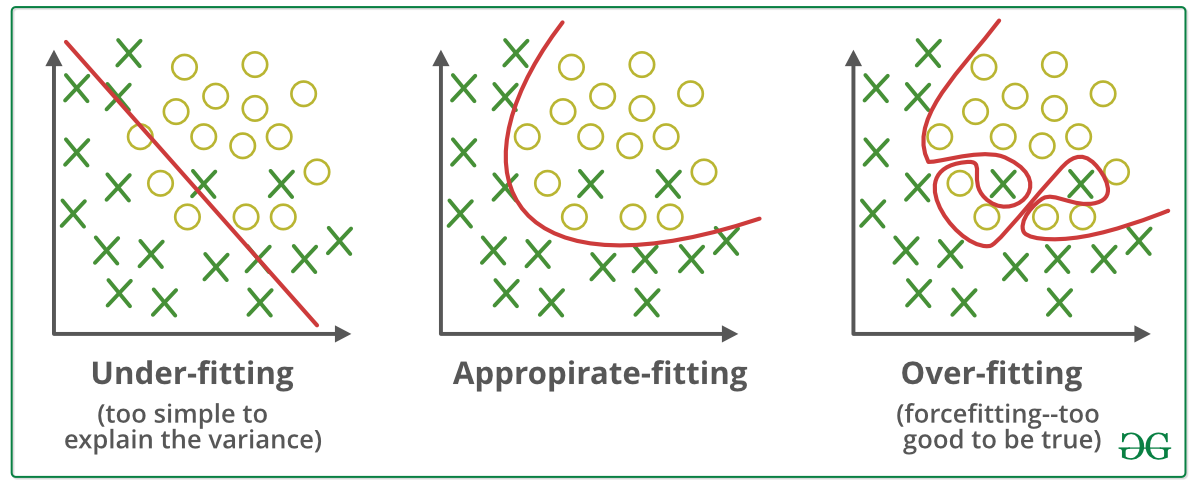


Причины переобучения(overfitting): 
- High variance and low bias 
- The model is too complex
- Training data is not enough

Как избавиться от переобучения:

- Cross-validation
- Train with more data
- Reduce model complexity
- Early stopping
- Regularization/ (Dropout for NN)
- Ensembling

Причины недообучения (underfitting):
- High bias and low variance 
- The size of the training dataset is not enough.
- The model is too simple.
- Training data is not cleaned and also contains noise in it.


Как избавиться от недообучения:

- увеличить набор параметров в модели
- выбрать другой алгоритм
- почистить данные от шума/выбросов
- увеличить время обучения и выбрать другую функцию ошибок

## практическая часть

In [2]:
# import os
import numpy as np
import pandas as pd
pd.set_option('max_columns', None) # не "прячет" колонки датафрейма

import matplotlib.pyplot as plt
import seaborn
 
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import linear_model

In [3]:
import warnings
warnings.filterwarnings('ignore') # так можно "спрятать" warnings

In [5]:
from sklearn.datasets import make_regression # генерация рандомного датасета для регрессии


### создание своего датасета (random seed, data exploration)

подробнее про [make classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [13]:
X, y =  make_regression(n_features=100,
    n_samples=1000, random_state=4) #np.random.randint(10000)

In [14]:
display(X.shape)
# X[:5, :4] # смотрим на часть матрицы признаков, а вообще она большая

(1000, 100)

In [15]:
X

array([[-0.31994976, -0.92182591, -0.54664867, ...,  0.4999914 ,
        -0.46429424, -1.34424305],
       [ 0.04854838, -0.9598683 , -0.30342198, ..., -1.22908595,
        -1.41378821,  0.94014758],
       [ 0.94780929, -1.8144559 , -0.8867069 , ..., -3.82085356,
         1.82816336, -1.99851151],
       ...,
       [-0.12018438,  0.39699838, -0.25440902, ...,  1.48588595,
         0.49756594, -0.20554758],
       [-0.20947864,  1.00956577,  0.05354459, ...,  0.24362963,
         0.55350166,  1.79569233],
       [-0.86573038,  1.05237476,  0.81247834, ..., -1.77601052,
         0.84452393,  0.20447688]])

In [16]:
display(y.shape)

y[:5] # часть вектора, каждое значение - это класс отдельного объекта 

(1000,)

array([-141.12340223,  111.90627101,   64.3875661 ,    4.79945791,
         37.24813168])

Теперь у нас есть матрица (X) с признаками и весами этих признаков, а еще есть вектор (y), определяющий каждый семпл в отдельный класс. Давайте посмотрим на признаки

In [17]:
features = pd.DataFrame(X) # сделаем матрицу датафреймом

In [18]:
answers = pd.DataFrame(y) # и вектор тоже

In [19]:
features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.319950,-0.921826,-0.546649,-0.292251,1.266784,-0.982670,-0.004361,-0.730027,-0.913792,0.321888,-0.290579,0.918984,-0.310648,1.428892,-0.527808,-0.596405,0.701714,-0.769462,0.124329,-1.279997,0.625557,1.251537,-0.526033,-0.010219,-0.490837,-1.844071,1.022634,1.031825,-0.104800,-1.393797,1.196704,2.127735,-0.403954,-0.416590,0.753670,2.176092,0.817234,1.265455,-0.460479,-0.495945,0.878796,0.835810,0.583122,-2.129199,-0.181660,0.711180,-0.337134,0.143118,-0.384565,0.862782,0.261678,0.485068,-1.160563,-1.080335,0.531993,-0.451733,-0.752277,-1.489813,-0.004529,-0.565235,0.542690,-0.548675,-1.476053,0.597981,1.223576,-0.499040,1.298046,0.710980,0.223604,0.288972,-0.165743,0.513934,0.051966,0.104682,-0.266596,-0.053500,0.541831,-1.268086,-0.880999,-1.653850,-0.534237,0.318405,-0.776120,1.292235,0.960993,-0.596332,-1.526079,-0.153609,-0.085122,-0.374795,0.190845,-0.890714,-0.760327,-0.917745,1.211589,0.945540,-1.921564,0.499991,-0.464294,-1.344243
1,0.048548,-0.959868,-0.303422,-2.008649,-0.389126,-1.132031,0.717009,-1.543669,-0.691899,1.672884,1.195243,-1.241897,0.004257,0.386472,-0.346747,-1.595780,1.056488,-1.463165,-1.318511,1.535283,-0.436356,-1.509770,1.405026,0.796804,-0.005558,0.035554,-1.068486,2.381062,0.346485,1.994818,2.046995,0.212897,-0.622060,0.932333,-0.582997,1.292341,-1.603672,-1.550572,0.431261,-0.284217,-1.187568,0.559840,-0.515568,-0.572104,-1.070274,2.327592,2.135429,-0.878472,0.982599,0.674585,-1.786027,-1.447874,1.131400,0.304092,-0.725074,-0.121870,-0.192286,-1.084929,0.469128,-0.526385,-0.570628,-0.820488,3.117446,1.284159,-0.122408,0.166892,0.496893,0.089598,0.486680,1.797285,0.192012,-0.145582,-0.569983,-1.573198,0.320302,1.694102,-1.120186,0.937239,0.258183,0.909515,0.959897,0.342533,-0.417312,0.867371,0.231910,-0.509560,-0.297052,0.194631,-0.955378,-0.395925,-0.838536,0.330624,-0.436363,0.980423,-0.215271,-0.964462,-0.403801,-1.229086,-1.413788,0.940148
2,0.947809,-1.814456,-0.886707,0.272663,-1.056264,2.028698,-0.672973,-0.250358,-2.004147,1.122405,-1.001378,0.484937,0.397228,0.303235,-0.717156,0.411953,1.390708,-0.944042,0.423514,-1.466213,0.868184,-0.625636,0.690840,0.679494,-0.888480,1.778038,-0.833449,0.274591,0.061707,0.472175,0.536793,-0.831739,0.354430,-1.493820,-0.024664,-0.905288,-0.398114,-0.136756,-2.779610,1.007910,0.168130,1.925657,1.979706,-0.376655,0.017112,0.440851,0.375309,-0.780854,1.445388,-0.612856,1.292233,-0.638673,-1.293647,0.951375,0.934676,-0.573812,1.798506,-0.359248,-1.783647,0.482611,1.547979,2.764830,-0.867324,-0.926682,-0.387062,-0.388120,0.014483,-0.737504,2.231698,-1.017426,0.833054,1.304158,-3.178293,-0.061255,-0.541242,-0.205446,-1.208720,-0.219098,0.209518,-1.025038,-0.044641,-0.909712,1.218272,0.324129,0.533094,0.623338,-1.002474,0.315371,-0.398823,1.344876,0.049531,-1.159312,-0.450684,0.503258,-0.296842,1.761211,-0.774506,-3.820854,1.828163,-1.998512
3,0.797783,0.009607,1.980726,-0.226115,-0.020712,-0.984877,0.006514,1.110908,-1.163390,2.508544,-0.769301,-0.286090,-0.644832,0.124183,1.117058,-1.854009,-1.102473,-0.817133,-0.373481,-0.670937,0.110170,-1.030868,0.602372,-0.610553,-0.024654,-0.966565,-0.152792,0.237485,-0.582734,-1.124165,-1.173220,-1.347811,-0.551675,0.377924,0.636452,-0.906660,-0.878975,-0.889491,-0.572534,-0.288519,-1.026445,-0.485381,1.805442,1.711524,-0.208398,-1.043814,0.033809,0.922916,-0.058920,0.156116,-0.781935,0.197718,0.948330,0.831258,-1.419183,0.145716,-0.804485,-1.165261,0.669797,-1.004306,1.125760,-0.371293,1.254379,0.945143,-0.476492,0.845382,-0.660065,-0.596211,-0.477979,1.659990,0.863186,-0.767486,-1.363221,0.764129,1.471038,0.654417,2.512122,-0.169454,-0.692982,0.680741,-0.163812,-1.565493,1.718681,0.355029,0.453075,-0.653403,1.197853,-1.325805

In [20]:
answers

,0
0,-141.123402
1,111.906271
2,64.387566
3,4.799458
4,37.248132
...,...
995,108.969801
996,79.232650
997,0.985117
998,268.353200


<AxesSubplot:title={'center':'Distribution of stds of all columns'}, ylabel='Frequency'>

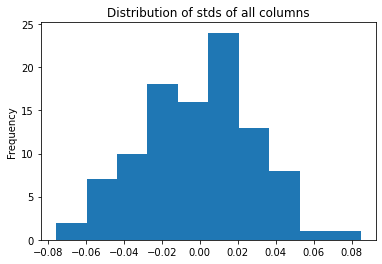

In [21]:
#данные не нормализованы, значения не от 0 до 1

# display(features.std()) # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.std.html

features.mean().plot(kind = 'hist', title ='Distribution of stds of all columns')


**распределены ли данные нормально?**

<AxesSubplot:title={'center':'Distribution of means of all columns'}, ylabel='Frequency'>

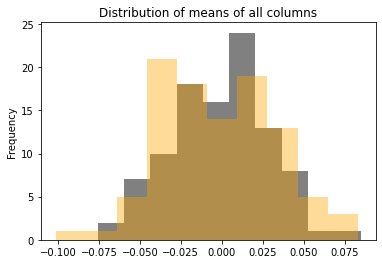

In [22]:
features.mean().plot(kind ='hist', title = 'Distribution of means of all columns',
                     color = 'gray')

features.median().plot(kind ='hist', title = 'Distribution of means of all columns',
                       color = 'orange', alpha = 0.4)

In [68]:
features.mean()

0     -0.220818
1     -0.015133
2      0.195772
3     -0.012546
4     -0.033779
         ...   
195    0.008210
196    0.811130
197   -0.004585
198    0.021731
199   -0.059244
Length: 200, dtype: float64

In [65]:
# проверим, что нет пустых значений
features.isnull().any().any() # добавление нового .any() уменьшает "размерность" проверяемого

# returns True if any item in an iterable are true, otherwise it returns False

False

In [23]:
#дисбаланс классов (можно регулировать в make_classification(weights=[0.7, 0.3])

answers[0].value_counts() # число в квадратных скобках - это индекс столбца, он у нас всего один

-141.123402    1
 337.901350    1
-102.824643    1
-197.194479    1
 1.169313      1
              ..
 4.771236      1
 265.934756    1
 78.176753     1
 228.621415    1
 301.042218    1
Name: 0, Length: 1000, dtype: int64

### обучение

In [24]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=42) 
# обратите внимание на test_size

In [25]:
np.mean(X_train, axis=0) # данные еще не нормированы, давайте это исправим

array([-2.56936608e-02, -1.64243614e-02, -7.09386631e-02,  3.17480179e-02,
        2.12523107e-02, -3.11710456e-02,  5.26819566e-02, -9.97815113e-03,
        5.10223842e-02,  1.12880491e-03,  2.49908722e-02, -3.17573049e-02,
       -1.80691305e-02,  1.37832673e-02, -2.93682728e-02, -4.00552077e-02,
       -4.39262452e-03,  4.13207359e-03, -2.03411338e-02,  6.87680415e-02,
       -2.18428540e-03, -2.98238631e-03,  1.00909700e-02, -1.14829973e-02,
       -5.84493558e-02, -2.32136580e-02,  4.09944448e-02,  6.61118875e-02,
        5.74018409e-02,  3.07857984e-02, -1.05744043e-02,  4.30880883e-02,
       -2.62838958e-02, -1.49988200e-03,  7.14845607e-02,  6.26013364e-03,
        4.84872755e-02,  1.27107700e-02, -1.11151474e-02, -2.20525305e-02,
       -2.01253967e-02,  2.54934732e-02, -6.05980780e-02,  3.24369746e-02,
        1.63036752e-02, -6.54255155e-03,  9.78414276e-04,  2.42686179e-02,
       -1.58786499e-02, -1.89307132e-02,  3.63660234e-02, -2.31600162e-02,
        2.55239572e-02, -

Данные нормируют, потому что дисбаланс между значениями признаков может негативно сказаться работе модели и ухудшить результаты обучения.

In [26]:
#Нормируем данные
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [76]:
display(np.mean(X_test, axis=0).min())
display(np.mean(X_test, axis=0).max())

-3.660071461270674

3.44670429787743

In [79]:
display(np.mean(X_train, axis=0).min())
display(np.mean(X_train, axis=0).max())

-2.565033805358977

3.795739100869067

Теперь у нас есть матрица признаков и их значений(весов), вектор с финальными значениями, все нормировано, можно обучаться

In [29]:
# обучимся на том, что есть, и оценим качество предсказаний на трейне
model = linear_model.LinearRegression()

model = model.fit(X_train, y_train)

train_preds = model.predict(X_train) 

test_preds = model.predict(X_test) 

In [30]:
test_preds

array([ 1.80954780e+02,  7.43111019e+01, -1.65263262e+02,  1.16931313e+00,
        2.88609952e+01, -1.20220869e+02, -3.14561321e+01,  1.16566183e+02,
        1.49609370e+02, -1.72756815e+02, -2.79130911e+02,  6.13338884e+01,
        4.66032900e+01, -1.23729305e+02,  1.98596824e+02, -8.15495145e+01,
       -6.11496434e+00,  2.51492273e+02,  6.73392080e+01, -8.06863639e+01,
       -3.90352400e+01, -7.21014769e+01, -5.39358754e+01,  2.57840268e+02,
       -9.43285729e+01, -4.18817502e+01,  1.18270422e+02,  2.06067478e+02,
        1.68885238e+02,  6.57262295e+01, -1.37259225e+02,  2.70176837e+02,
        1.91812805e+02,  6.20929514e+01, -6.76316327e+01, -1.39123697e+02,
        8.90481254e+01,  2.02263786e+02, -1.01831578e+02,  1.39196367e+02,
        1.15082526e+02, -1.70600550e+02,  1.10064506e+02, -2.19282641e+02,
       -1.66781778e+02,  1.17089568e+02, -1.55189494e+01,  3.65422613e+02,
       -1.21940658e+02, -1.17749388e+02,  1.67058554e+00,  2.07087162e+02,
       -1.81886384e+02, -

In [92]:
pd.DataFrame(y_train)[:3]

,0
0,1
1,1
2,0


In [32]:
pd.DataFrame(model.predict(X_train))[:3] 

,0
0,134.395397
1,159.265286
2,-247.116825
